# 1. Introduction

In the last few years, the area of computer vision has undergone substantial development. This branch of technology is dedicated to the comprehensive set of processes involved in obtaining, processing, analyzing, and comprehending digital images to extract meaningful information.

One key technique among these processes is known as image segmentation. This specific method plays a crucial role in dividing an image into parts or segments to simplify or change the representation of an image into something that is more meaningful and easier to analyze. Image segmentation is fundamental in identifying objects and boundaries (lines, curves, etc.) in images, making it a critical step in many computer vision tasks.

Image segmentation plays a pivotal role in medical imaging by enabling precise segmentation of brain tumors. This technique facilitates accurate tumor identification and boundary delineation within MRI scans, which is essential for diagnosis, treatment planning, and monitoring the progression of brain tumors. By automating and enhancing the analysis of medical images, image segmentation significantly contributes to improved patient outcomes in the field of neuro-oncology.

# 2. Dataset Information

The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:
1. **Native (T1)**
2. **Post-contrast T1-weighted (T1ce - contrast enhanced)**
3. **T2-weighted (T2)**
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)**

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
  1. **Label 0**: Not Tumor (NT) volume
  2. **Label 1**: Necrotic and non-enhancing tumor core (NCR/NET)
  3. **Label 2**: Peritumoral edema (ED)
  4. **Label 3**: Missing (No pixels in all the volumes contain label 3)
  5. **Label 4**: GD-enhancing tumor (ET)

As there are no pixels with the label 3, we will be replacing label 3 with label 4 so that there is continuity between the labels.

# 3. Load and Explore the Dataset

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    ModelCheckpoint, 
    CSVLogger, 
    EarlyStopping
)
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize

import cv2
import random
import glob
import PIL

In [5]:
# مسیر فایل T1
t1_path = 'C:/Users/LENOVO/Desktop/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1.nii'
# خواندن فایل
test_image_t1 = nib.load(t1_path).get_fdata()

# بررسی ابعاد تصویر"
print("Shape :", test_image_t1.shape)
print("Dtype :", test_image_t1.dtype)

Shape : (240, 240, 155)
Dtype : float64


In [7]:
print("Min: ", test_image_t1.min())
print("Max: ", test_image_t1.max())

Min:  0.0
Max:  709.0


Raw MRI pixel values often span a wide range (e.g., 0 to 2000). Scalers map these values to a standardized range (e.g., [0, 1] or [-1, 1]), ensuring consistency across datasets.


##### MinMaxScaler  :	  (X - Xmin ) /  Xmax - Xmin 

### Why We Use Scalers in Medical Image Processing
Scalers (normalization techniques) are critical in medical image processing, particularly for MRI-based tasks like brain tumor segmentation. Here’s a detailed breakdown of their i
1. Improved Model Convergence
Deep learning models (e.g., U-Net) require input features to be on similar scales for stable training:

Why?

Large values can saturate activation functions (e.g., sigmoid).

Wide value ranges destabilize gradient updates during backpropagation.

2. Enhanced Contrast
Scalers amplify subtle differences between tissues, making it easier for models to distinguish tumor regions from healthy tissues.

Example:
A tumor’s intensity might jump from 1500 → 0.8 after scaling, while healthy tissue goes from 200 → 0.1, improving contrast.

3. Harmonization of Multi-Modal Data
MRI scans often include multiple modalities (e.g., T1ce, FLAIR) with different value ranges. Scalers align these modalities:

T1ce: [0, 1500] → [0, 1]

FLAIR: [0, 2000] → [0, 1]

4. Numerical Stability
Scaled inputs prevent computational issues like gradient explosion during matrix operations in neural networks.

5. Faster Training
Optimization algorithms (e.g., Adam) converge faster when inputs are normalized, reducing training time.

In [8]:
scaler = MinMaxScaler()

In [9]:
t1_image = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

In [10]:
print("Min: ", t1_image.min())
print("Max: ", t1_image.max())

Min:  0.0
Max:  1.0


In [11]:
# rescaling FLAIR
test_image_flair = nib.load('C:/Users/LENOVO/Desktop/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii').get_fdata()
test_image_flair= scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load('C:/Users/LENOVO/Desktop/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load('C:/Users/LENOVO/Desktop/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask 
# If we rescale the mask, these discrete values will be converted into decimal numbers and will lose their meaning.
test_image_seg = nib.load('C:/Users/LENOVO/Desktop/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii').get_fdata()

Slice Number: 95


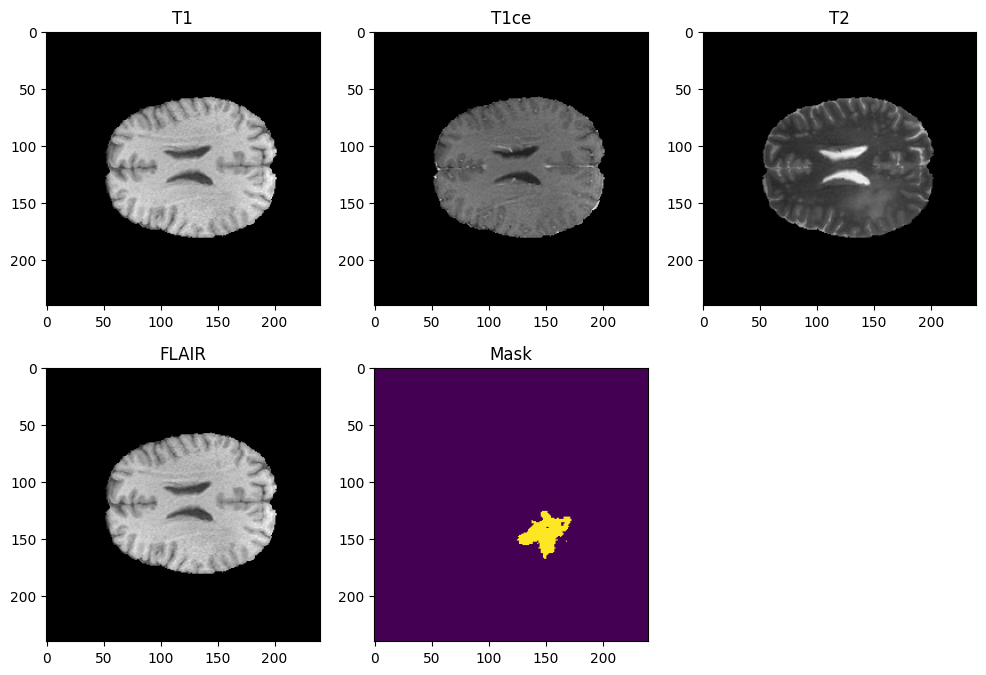

In [35]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

#### The four MRI modalities offer complementary insights into brain anatomy:

T1 (Native): Reveals tissue structure, critical for detecting tumors and cysts.

T1ce (Contrast-Enhanced): Uses gadolinium to enhance abnormality visibility.

T2: Highlights fluid content in tissues.

T2-FLAIR: Suppresses fluid signals to improve lesion detection in white matter.

For AI-driven segmentation, we prioritize T1ce (superior clarity over T1) and T2-FLAIR (reduced fluid interference vs. T2) to balance accuracy and computational efficiency.

Image Format:

NIfTI (.nii): Standard 3D neuroimaging format with spatial metadata.

Data Structure: All modalities and masks share identical dimensions (e.g., 240×240×155).


In [13]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


As we can see, the modalities and segmentations have 3 dimensions. Each dimension consists of a series of two-dimensional images, known as slices, which all contain the same number of pixels and are stacked together to create this 3D representation. For instance, in our previous example, we displayed the 95th slice of a certain dimension.

These 3 dimensions correspond to the three spatial dimensions of the image: width, height, and depth. In medical imaging, these dimensions are referred to as the axial (transverse), coronal, and sagittal planes, corresponding to the three main orientations of the human body and, therefore, the human brain.

Here is a quick presentation of these 3 planes:

1. **Axial (Transverse) Plane:** This plane divides the body into upper and lower parts and is perpendicular to the long axis of the body. In brain imaging, an axial slice is a horizontal cut through the brain.
2. **Coronal (Frontal) Plane:** This plane divides the body into front (anterior) and back (posterior) parts. A coronal slice in brain imaging is a vertical cut from one side of the head to the other, dividing the brain into front and back sections.
3. **Sagittal (Lateral) Plane:** This plane divides the body into left and right parts. A sagittal slice in brain imaging is a vertical cut from front to back, dividing the brain into left and right sections.

Understanding these planes is crucial for accurately interpreting medical images and effectively utilizing them in segmentation tasks. Each plane provides a different perspective, helping to localize and identify anatomical structures and abnormalities.

Slice number: 95


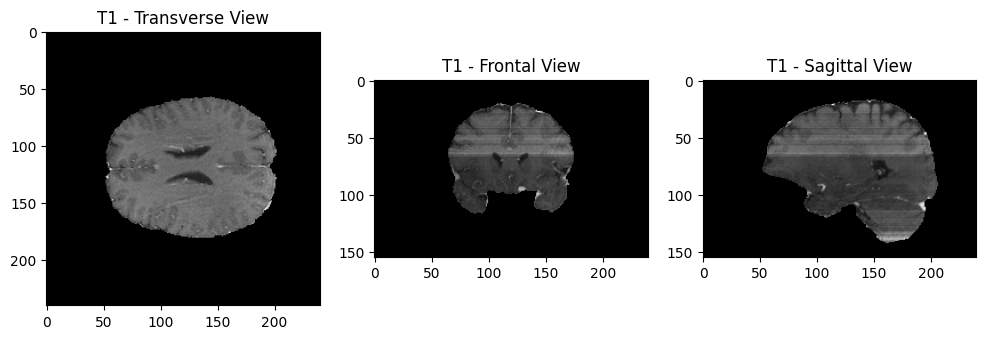

In [14]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

# 5. Split the Dataset
Optimized Dataset Splitting Strategy
For effective model development, we divide our dataset into three distinct subsets:

 1. Training Set (70-80%) - Primary data for model learning

 2. Validation Set (10-15%) - Used for hyperparameter tuning and overfitting detection

 3. Test Set (10-15%) - Final evaluation of model performance

*Key Considerations* :

Stratified Splitting (recommended for imbalanced datasets): Preserves original class distributions across all subsets

Random Splitting: Simple alternative for balanced datasets

Robust Evaluation: Ensures reliable performance on unseen data

This structured approach guarantees model generalizability while maintaining statistical integrity throughout the development process.


In [15]:
TRAIN_DATASET_PATH =  "C:/Users/LENOVO/Desktop/BraTs2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [16]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


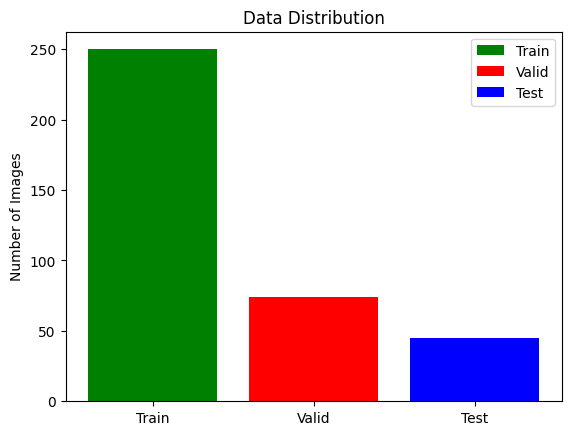

In [17]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

# 6. DataGenerator


To train a neural network for image segmentation, we need both raw image data (X) and ground truth segmentations (y). This allows the network to learn tumor patterns and make accurate predictions from patient scans. However, directly loading all 3D images can overload system memory and cause shape mismatch errors. Therefore, we use a Data Generator for image preprocessing, which includes several steps:

1. **Retrieve paths:** Obtain the paths for the T1CE and FLAIR modalities (for complementary anatomical and tissue contrast information) and the ground truth segmentation.
2. **Load data:** Load the selected slices (60-135) from these modalities and the corresponding segmentation.
3. **Create arrays:** Form X arrays with the slices from T1CE and FLAIR, and y arrays with the segmentation slices.
4. **Class reassignment:** Assign a value of 3 to all instances of 4 in the mask array to correct the missing class issue.

Additional preprocessing steps include:

- **Axial plane:** Use the axial plane for its square shape (240x240). This enables visualizing predictions across all planes without impact.
- **One-Hot Encoding:** Apply One-Hot Encoding to the y array to convert classes (0 to 3) into a numerical format suitable for neural networks, avoiding any implied hierarchy between classes. Here is what it consists of, for one slice:
- **Resize images:** Resize each slice from (240x240) to (128x128). This shape is chosen because it is a power of two, fitting well with pooling layers (MaxPooling2D) in CNNs, and balances computational efficiency and information preservation.

While resizing to (256x256) could retain more detail, it significantly increases training time and memory usage. We can choose to train with (256x256) images, but we’ll need to adjust your U-Net architecture accordingly.

Now that we have a clear understanding of our data and preprocessing steps, we can proceed to prepare our model for training.

In [18]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [19]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'  # X: (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(Batch_ids):
            # استفاده از TRAIN_PATH به عنوان دایرکتوری اصلی (TRAIN PATH درسته)
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            # بارگذاری فایل‌های مربوط به FLAIR، T1ce و segmentation
            flair_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(flair_path).get_fdata()

            t1ce_path = os.path.join(case_path, f'{i}_t1ce.nii')
            t1ce = nib.load(t1ce_path).get_fdata()

            seg_path = os.path.join(case_path, f'{i}_seg.nii')
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # تغییر مقادیر segmentation (برای مثال تغییر 4 به 3)
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y

# تعریف ژنراتورها
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


### Preprocessing Steps Summary

- **Data Generator:** Utilized to process and send data to the neural network without overloading memory.
- **Epoch Handling:** For each epoch, the model processes 250 samples from the training dataset.
- **Sample Analysis:** Each sample consists of 150 slices (100 slices each from two modalities) resized to (128, 128).
- **Data Shapes:**
  - **X Array:** Shape (128, 128, 100, 2) for input images.
  - **Ground Truth (y):** One-Hot encoded segmentation with shape (100, 128, 128, 4).

This preprocessing setup ensures efficient data handling and preparation for training the neural network.

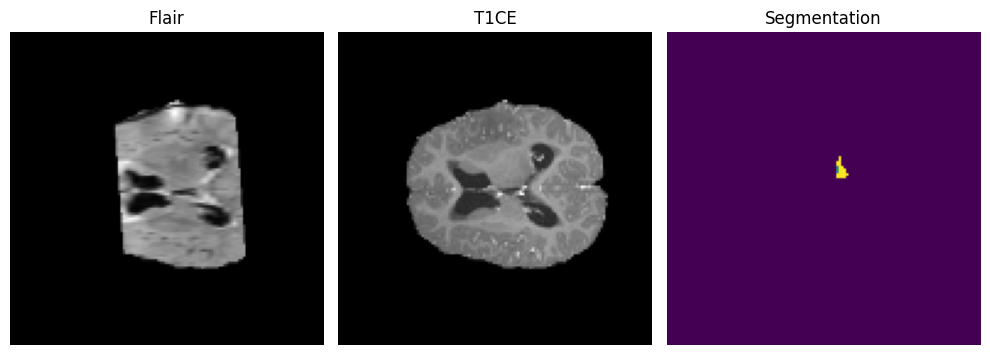

In [20]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)


# 7. Loss Function and Evaluation Metrics

In [21]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [22]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

In [23]:
# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [24]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [25]:
# ========================== Training Setup ==================================
# Initialize model
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)


# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4, weight_decay=1e-5),
    loss= "categorical_crossentropy" ,
    metrics=  ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing]
)

# Callbacks
callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                          verbose=1, save_best_only=True, save_weights_only = True),
      CSVLogger('training.log', separator=',', append=False)
    ]


In [33]:
K.clear_session()

In [34]:
# ============================= Training =====================================
history = model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks,
    verbose = True
)

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9690 - mean_io_u: 0.5935 - dice_coef: 0.2586 - precision: 0.9627 - sensitivity: 0.9489 - specificity: 0.9944 - dice_coef_necrotic: 0.0394 - dice_coef_edema: 0.1050 - dice_coef_enhancing: 0.0345
Epoch 1: val_loss improved from inf to 0.07676, saving model to model_.01-0.076761.m5
250/250 [==============================] - 1759s 7s/step - loss: 0.1425 - accuracy: 0.9690 - mean_io_u: 0.5935 - dice_coef: 0.2586 - precision: 0.9627 - sensitivity: 0.9489 - specificity: 0.9944 - dice_coef_necrotic: 0.0394 - dice_coef_edema: 0.1050 - dice_coef_enhancing: 0.0345 - val_loss: 0.0768 - val_accuracy: 0.9835 - val_mean_io_u: 0.7188 - val_dice_coef: 0.2674 - val_precision: 0.9835 - val_sensitivity: 0.9835 - val_specificity: 0.9945 - val_dice_coef_necrotic: 0.0339 - val_dice_coef_edema: 0.0947 - val_dice_coef_enhancing: 0.0269 - lr: 1.0000e-04
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss:

In [39]:
model.save("unet.keras")

In [42]:
model = keras.models.load_model('unet.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

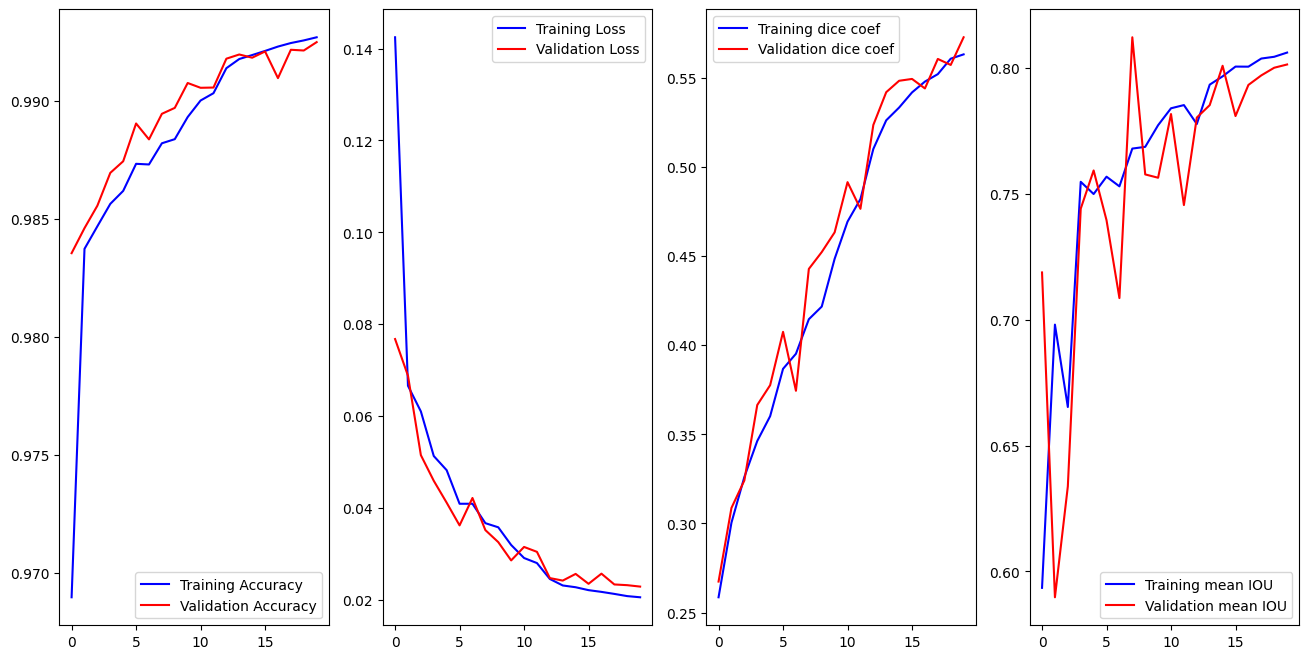

In [43]:
history = pd.read_csv('training.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()